In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_mit = import_mit_data()

In [6]:
beats = []
freq = 360

for i,patient in tqdm(enumerate(data_mit), total=len(data_mit)):
    for waveform, label in patient:
        rpeaks = wfdb.processing.xqrs_detect(waveform, fs=freq, verbose=False)

        for peak in rpeaks:
            if peak >= freq/2 and peak < len(waveform) - freq/2:
                partial_wave = waveform[peak-freq//2:peak+freq//2]
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                beats.append((partial_wave, label, i)) 

100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


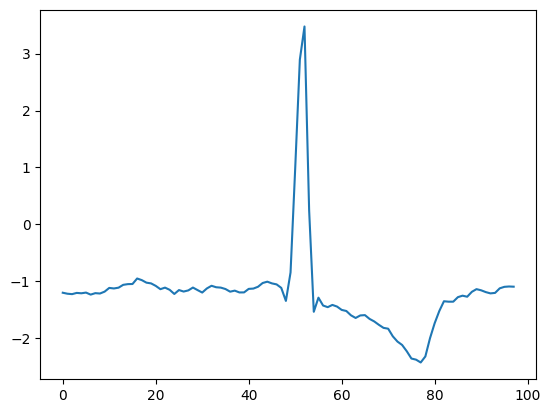

In [7]:
def plotbeat(x):
    if type(x) is tuple:
        plt.plot(x[0])
    else:
        plt.plot(x)

plotbeat(beats[0])

# Dataset

In [8]:
labels = list(set([x[1] for x in beats]))
label_map = {label:i for i,label in enumerate(labels)}

In [86]:
class BeatDataset(Dataset):
    def __init__(self, data, device, label_map, specify_patient=None):
        self.data = []

        for waveform, label, patient in tqdm(data):
            if specify_patient:
                if patient != specify_patient:
                    continue
                

            ## Z-score Normalisation
            waveform = (waveform - waveform.mean()) / waveform.std()

            self.data.append((
                torch.tensor(waveform, device=device, dtype=torch.float32),
                torch.tensor(label_map[label], device=device),
                patient
            ))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        waveform, label, patient = self.data[idx]

        return waveform, label
    
# beat_dataset = BeatDataset(random.sample(beats, 10), device, label_map)
beat_dataset = BeatDataset(beats, device, label_map)
beat_dataloader = DataLoader(beat_dataset, batch_size=128, shuffle=True)

100%|██████████| 76851/76851 [00:05<00:00, 12871.93it/s]


In [79]:
class Encoder(nn.Module):
    def __init__(self, lstm_count=32):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=lstm_count, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)

        self.fc_encoding_1 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_encoding_2 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_encoding_3 = nn.Linear(lstm_count*2, lstm_count)

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        _, hidden = self.lstm2(x)

        x = torch.cat(hidden, axis=2)
        x = x.squeeze(0)

        x = self.fc_encoding_1(x)
        x = F.sigmoid(x)
        x = self.fc_encoding_2(x)
        x = F.sigmoid(x)
        x = self.fc_encoding_3(x)
        x = F.sigmoid(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, seq_len=98, lstm_count=32):
        super().__init__()

        self.seq_len = seq_len
        self.lstm_count = lstm_count
        
        self.lstm1 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)
        self.output_layer = nn.Linear(lstm_count, 1)

        self.fc_decoding_1 = nn.Linear(lstm_count, lstm_count*2)
        self.fc_decoding_2 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_decoding_3 = nn.Linear(lstm_count*2, lstm_count*2)

    def forward(self, x):
        x = self.fc_decoding_1(x)
        x = F.sigmoid(x)
        x = self.fc_decoding_2(x)
        x = F.sigmoid(x)
        x = self.fc_decoding_3(x)

        x = x.unsqueeze(0)

        x = [x[:,:,:self.lstm_count].contiguous(),x[:,:,self.lstm_count:].contiguous()]

        x,_ = self.lstm1(torch.zeros([x[0].shape[1], self.seq_len, x[0].shape[2]], device=x[0].device), x)
        x = self.dropout(x)
        x,_ = self.lstm2(x)
        x = self.output_layer(x)

        return x.squeeze(2)

class AEModel(nn.Module):
    def __init__(self, lstm_count=32):
        super().__init__()

        self.encoder = Encoder(lstm_count=lstm_count)
        self.decoder = Decoder(lstm_count=lstm_count)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AEModel(lstm_count=16).to(device)
model_path = 'autoencoder16.pt'
model.load_state_dict(torch.load(model_path), strict=False)

_IncompatibleKeys(missing_keys=['encoder.fc_encoding_1.weight', 'encoder.fc_encoding_1.bias', 'encoder.fc_encoding_2.weight', 'encoder.fc_encoding_2.bias', 'encoder.fc_encoding_3.weight', 'encoder.fc_encoding_3.bias', 'decoder.fc_decoding_1.weight', 'decoder.fc_decoding_1.bias', 'decoder.fc_decoding_2.weight', 'decoder.fc_decoding_2.bias', 'decoder.fc_decoding_3.weight', 'decoder.fc_decoding_3.bias'], unexpected_keys=[])

In [80]:
# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters in encoder.fc_encoding
for param in model.encoder.fc_encoding_1.parameters():
    param.requires_grad = True
for param in model.encoder.fc_encoding_2.parameters():
    param.requires_grad = True
for param in model.encoder.fc_encoding_3.parameters():
    param.requires_grad = True

# Unfreeze the parameters in decoder.fc_decoding
for param in model.decoder.fc_decoding_1.parameters():
    param.requires_grad = True
for param in model.decoder.fc_decoding_2.parameters():
    param.requires_grad = True
for param in model.decoder.fc_decoding_3.parameters():
    param.requires_grad = True

In [81]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

losses = []

In [87]:
for epoch in range(10000):
    model.train()

    for i,batch in enumerate(beat_dataloader, 0):

        optimizer.zero_grad()

        seq, label = batch

        seq_pred = model.forward(seq)

        loss = criterion(seq, seq_pred)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.)
        optimizer.step()

    if epoch % 10 == 0:
        model.eval()

        totalloss = 0.

        with torch.no_grad():
            for i,batch in enumerate(beat_dataloader, 0):
                seq, label = batch

                seq_pred = model.forward(seq)

                loss = criterion(seq, seq_pred)

                totalloss += loss.item()

        print(f'epoch {epoch}, loss {totalloss}')
        losses.append(totalloss)

    # if epoch % 100 == 0:
    #     torch.save(model.state_dict(), model_path)

epoch 0, loss 419.02453273534775
epoch 10, loss 363.7326498031616
epoch 20, loss 377.7375382781029
epoch 30, loss 356.28656071424484
epoch 40, loss 335.22067108750343
epoch 50, loss 331.79764541983604
epoch 60, loss 318.17069151997566
epoch 70, loss 320.32465904951096
epoch 80, loss 309.64430525898933
epoch 90, loss 326.92664885520935
epoch 100, loss 296.83240336179733
epoch 110, loss 294.08594501018524
epoch 120, loss 292.0645827949047


KeyboardInterrupt: 

In [14]:
torch.save(model.state_dict(), model_path)

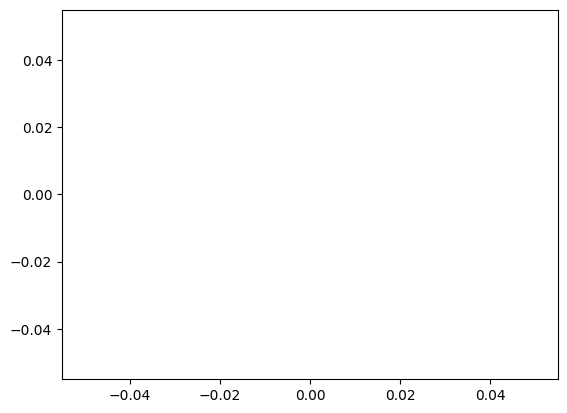

In [15]:
# plt.plot([np.log(x) for x in losses])
plt.plot(losses[150:])

Text(0.5, 1.0, 'Autoencoder replicated heartbeat')

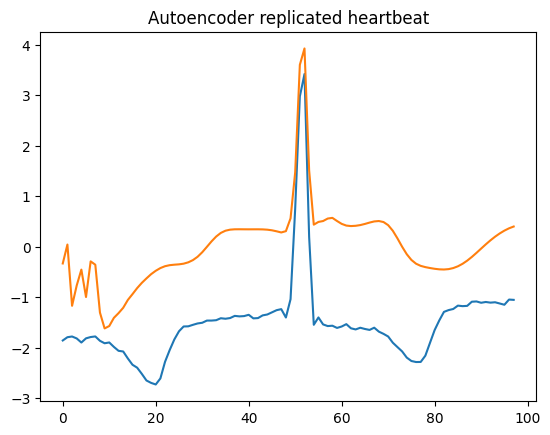

In [119]:
# i = 12425
# i=11422
i = 1552

seq, label, _ = beats[i]
seq = torch.tensor(seq, dtype=torch.float32, device=device)
seq = seq.reshape((1,98))
model.eval()
seq_pred = model.forward(seq)

plt.plot(seq.detach().cpu().numpy().reshape(-1))
plt.plot(seq_pred.detach().cpu().numpy().reshape(-1))

plt.title('Autoencoder replicated heartbeat')


# Distribution Difference

In [12]:
users = [{key:[] for key in label_map.keys()} for i in range(48)]

for beat in beats:
    users[beat[2]][beat[1]].append(beat[0])

In [13]:
label_map

{'R': 0, 'L': 1, 'V': 2, 'N': 3, 'P': 4}

In [97]:
[len(x) for x in users[14].values()]

[0, 0, 0, 1814, 3]

In [100]:
def encode(beats):
    values = np.stack(beats, axis=1).reshape((-1, 98))
    seq = torch.tensor(values, dtype=torch.float32, device=device)
    model.eval()
    with torch.no_grad():
        encoded = model.encoder.forward(seq)
    # encoded = torch.concat(encoded, dim=2).squeeze(0)
    return encoded

def relative_entropy(beats_1, beats_2):
    encode_1 = encode(beats_1).detach().cpu().numpy()
    encode_2 = encode(beats_2).detach().cpu().numpy()

    kde_D1 = KernelDensity(bandwidth=1.0, kernel='gaussian').fit(encode_1)
    kde_D2 = KernelDensity(bandwidth=1.0, kernel='gaussian').fit(encode_2)

    # X = np.vstack([encode_1, encode_2])
    X = np.vstack([encode_1[:min(len(encode_1), len(encode_2))], encode_2[:min(len(encode_1), len(encode_2))]])
    # X = np.vstack([random.sample(encode_1, min(len(encode_1), len(encode_2))), random.sample(encode_2, min(len(encode_1), len(encode_2)))])

    log_prob_D1 = kde_D1.score_samples(X)
    log_prob_D2 = kde_D2.score_samples(X)

    prob_D1 = np.exp(log_prob_D1)
    prob_D2 = np.exp(log_prob_D2)

    # Calculate the KL divergence
    kl_divergence = jensenshannon(prob_D1, prob_D2)

    # print(kl_divergence)

    return kl_divergence

group_1 = users[14]['N'][:1000]
group_2 = users[14]['N'][1000:]
# group_2 = users[12]['N'][:1000]
# group_2 = users[20]['R'][:1000]

relative_entropy(group_1, group_2)

0.010338176641343835

In [16]:
category = 'N'

groups = []
for patient in users:
    if len(patient[category]) > 1000:
        groups.append(patient[category])

len(groups)

31

In [17]:
groups[0]

[array([-1.20070782, -1.21801043, -1.22542045, -1.2038028 , -1.21033699,
        -1.19817389, -1.23374551, -1.20804234, -1.21456316, -1.18155497,
        -1.1160148 , -1.12570035, -1.11182615, -1.06206874, -1.04961426,
        -1.04734924, -0.95059632, -0.97930393, -1.0236692 , -1.03675511,
        -1.08022628, -1.13823406, -1.11080091, -1.14971733, -1.22239451,
        -1.15378332, -1.17986414, -1.15996479, -1.10983113, -1.15452058,
        -1.1974418 , -1.1253836 , -1.07845908, -1.10442328, -1.1109325 ,
        -1.13561771, -1.18198587, -1.163835  , -1.19578387, -1.19475019,
        -1.13311788, -1.12758926, -1.09589422, -1.02986871, -1.00650568,
        -1.03667418, -1.0542451 , -1.1150593 , -1.34462453, -0.84444692,
         0.98269723,  2.89408605,  3.4772492 ,  0.24458404, -1.53562384,
        -1.2873409 , -1.4256855 , -1.45416893, -1.41479383, -1.44365438,
        -1.50231405, -1.52162555, -1.59770791, -1.64396534, -1.59977963,
        -1.59405219, -1.66069974, -1.70503409, -1.7

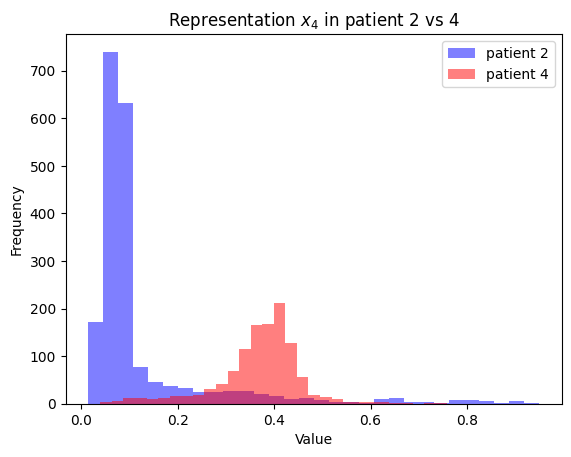

In [117]:
def plot_hist_comparison(groups, a, b, i):
    A = encode(groups[a]).detach().cpu().numpy()
    B = encode(groups[b]).detach().cpu().numpy()

    plt.hist(A[:,i], bins=30, alpha=0.5, label='Dataset 1', color='blue')  # Dataset 1 in blue
    plt.hist(B[:,i], bins=30, alpha=0.5, label='Dataset 2', color='red')   # Dataset 2 in red

    # Adding labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Representation $x_{i}$ in patient {a} vs {b}')
    plt.legend([f'patient {a}', f'patient {b}'])

    # Display the plot
    plt.show()

plot_hist_comparison(groups, 2, 4, 4)

In [ ]:
avg_intergroup = 0
for group in groups:
    avg_intergroup += relative_entropy(group[:len(group)//2], group[len(group)//2:])

avg_intergroup /= len(groups)

avg_betweengroup = 0
count = 0
for i in tqdm(range(len(groups))):
    for j in range(i+1, len(groups)):
        avg_betweengroup += relative_entropy(groups[i], groups[j])
        count += 1

avg_betweengroup /= count

100%|██████████| 31/31 [04:39<00:00,  9.02s/it]


In [ ]:
print(avg_intergroup, avg_betweengroup)

0.13391881274500528 0.5520462977884323


In [ ]:
len(groups)

31

In [43]:
y = encode(groups[0]).detach().cpu().numpy()
x = encode(groups[1]).detach().cpu().numpy()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,
          2.,   1.,   0.,   1.,   1.,   2.,   5.,   0.,   0.,   8.,   5.,
          6.,   4.,   9.,  14.,  11.,   7.,  19.,  17.,  25.,  44.,  60.,
         73.,  99., 129., 149., 142., 173., 152., 135.,  86.,  66.,  44.,
         44.,  34.,  28.,  23.,  32.,  14.,  14.,  11.,  10.,   9.,   6.,
          7.,   4.,   6.,   2.,   5.,   3.,   5.,   2.,   4.,   1.,   2.,
          0.,   0.,   1.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4.39184248e-01, -4.32999402e-01, -4.26814526e-01, -4.20629680e-01,
        -4.14444804e-01, -4.08259958e-01, -4.02075082e-01, -3.95890236e-01,
        -3.89705360e-01, -3.83520514e-01, -3.77335638e-01, -3.71150792e-01,
        -3.64965945e-01, -3.58781070e-01, -3.52596223e-01, -3.46411347e-01,
        -3.402

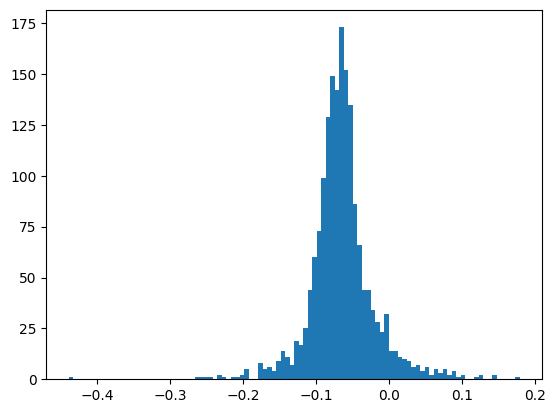

In [45]:
plt.hist(x[:,9], bins=100)